In [158]:
#%%writefile pymate.py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class male:

    def __init__(self, m, g, gene=0.0):

        self.id = m
        self.group_id = g
        self.quality = np.random.uniform(0.1, 0.9)
        self.competitive_effort = gene
        self.gene = gene
        self.rank = "N/A"


class female:

    def __init__(self,
                 f,
                 max_non_cycling_days,
                 conception_probability_list,
                 mean_days_to_conception,
                 sd_days_to_conception,
                 g,
                 gene=0.0):

        self.id = f
        self.group_id = g
        self.days_until_cycling = random.randint(0, max_non_cycling_days + 1)
        self.conception_probability_list = conception_probability_list
        self.conception_probability = "N/A"
        self.status = "not yet cycling"
        self.cycle_day = "N/A"
        self.gene = gene

        self.days_until_conception = abs(
            round(
                np.random.normal(mean_days_to_conception,
                                 sd_days_to_conception)))

    def switch_to_cycling(self, not_yet_cycling, females_cycling):

        females_cycling.append(self)
        not_yet_cycling.remove(self)
        self.status = "cycling"
        self.days_until_cycling = "N/A"

        self.cycle_day = 0
        self.conception_probability = self.conception_probability_list[
            0]  # starts day 0

    def switch_to_finished_cycling(self, females_cycling, finished_cycling):

        finished_cycling.append(self)
        females_cycling.remove(self)
        self.status = "finished cycling"
        self.cycle_day = "N/A"

        self.conception_probability = "N/A"


class group:

    # when a 'group' object is initialized, 'male' and 'female' objects are automatically instantiated in lists
    # ('males' and 'females') contained in the 'group' object
    # the male dominance hierarchy is set when the 'setRanks' method runs during 'group' initialization

    def __init__(self, g, max_non_cycling_days, conception_probability_list,
                 mean_days_to_conception, sd_days_to_conception):

        self.id = g
        self.females_not_yet_cycling = [
            female(f,
                   max_non_cycling_days,
                   conception_probability_list,
                   mean_days_to_conception,
                   sd_days_to_conception,
                   g=self.id) for f in range(number_females)
        ]

        self.females_cycling = []
        self.females_finished_cycling = []

        self.males = [male(m, g=self.id) for m in range(number_males)]

        self.mating_matrix = np.array(
            [np.array([1e-40] * number_males) for f in range(number_females)])

        self.list_of_rank_quality_corrlations = np.array([])

    def set_ranks(self):
        #         self.rank_entries = [(m.quality * m.competitive_effort) +
        #                              random.uniform(0, 1 - m.competitive_effort)
        #                              for m in self.males]

        #         self.rank_entries_scaled = [
        #             e / sum(self.rank_entries) for e in self.rank_entries
        #         ] if sum(self.rank_entries) > 0 else [
        #             1 / number_males for r in self.rank_entries
        #         ]

        self.rank_entries = [m.competitive_effort + 1e-50 for m in self.males]

        self.rank_entries_scaled = [
            e / sum(self.rank_entries) for e in self.rank_entries
        ]

        self.ranks = np.random.choice(range(number_males),
                                      p=self.rank_entries_scaled,
                                      size=number_males,
                                      replace=False)

        for i, m in enumerate(self.males):
            m.id = np.where(self.ranks == i)[0][0]
            m.rank = m.id

        np.append(
            self.list_of_rank_quality_corrlations,
            np.corrcoef([m.id for m in self.males],
                        [m.quality for m in self.males])[1, 0])

    def start_cycling(self):

        switch_to_cycling_list = []

        for f in self.females_not_yet_cycling:
            f.days_until_cycling -= 1
            if f.days_until_cycling < 0:
                switch_to_cycling_list.append(f)

        [
            f.switch_to_cycling(self.females_not_yet_cycling,
                                self.females_cycling)
            for f in switch_to_cycling_list
        ]

    def end_cycling(self, switch_to_finished_cycling_list):

        [
            f.switch_to_finished_cycling(self.females_cycling,
                                         self.females_finished_cycling)
            for f in switch_to_finished_cycling_list
        ]

    def make_mating_pairs(self):

        for m, f in enumerate(np.random.permutation(
                self.females_cycling)):  #randomize cycling females
            self.mating_matrix[
                f.id][m] += f.conception_probability * self.males[m].quality

    def go_one_day(self):

        self.start_cycling()

        switch_to_finished_cycling_list = []
        for f in self.females_cycling:
            f.days_until_conception -= 1
            if f.days_until_conception < 0:
                switch_to_finished_cycling_list.append(f)
            else:
                f.cycle_day = f.cycle_day + 1 if f.cycle_day < cycle_length - 1 else 0
                f.conception_probability = f.conception_probability_list[
                    f.cycle_day]

        self.end_cycling(switch_to_finished_cycling_list)

        self.make_mating_pairs() if any(
            [f.conception_probability for f in self.females_cycling]
        ) else 0  # only run function to make mating pairs if conception is possible

    def go_one_mating_season(self):

        self.set_ranks()
        self.males = sorted(self.males, key=self.sort_by_id)

        while len(self.females_finished_cycling) < number_females:
            self.go_one_day()

    def determine_next_gen_parents(self):

        self.females_finished_cycling = sorted(self.females_finished_cycling,
                                               key=self.sort_by_id)

        total_conception_probabilities = []
        self.parents = []

        for f in range(number_females):
            self.mating_matrix[f] = [
                fms / sum(self.mating_matrix[f])
                for fms in self.mating_matrix[f]
            ]

        for _ in [0, 1]:
            for mother in self.females_finished_cycling:

                potential_fathers = np.random.choice(self.males, size=3)

                father = random.choices(potential_fathers,
                                        weights=self.mating_matrix[mother.id][[
                                            p.id for p in potential_fathers
                                        ]],
                                        k=1)[0]

                self.parents.append([mother, father])

    def generate_offspring(self, max_non_cycling_days,
                           conception_probability_list,
                           mean_days_to_conception, sd_days_to_conception):

        self.females_not_yet_cycling = []
        self.males = []

        self.parents = np.random.permutation(
            self.parents)  # randomize order to avoid biasing offspring sex

        for i, p in enumerate(
                self.parents[:number_females]
        ):  # loop through parents until reaching number females
            new_gene = np.random.choice([p[0].gene, p[1].gene])
            self.females_not_yet_cycling.append(
                female(i,
                       max_non_cycling_days,
                       conception_probability_list,
                       mean_days_to_conception,
                       sd_days_to_conception,
                       g=self.id,
                       gene=new_gene))

        for i, p in enumerate(
                self.parents[number_males:]
        ):  # loop through remaining parents until reaching number males
            new_gene = np.random.choice([p[0].gene, p[1].gene])
            self.males.append(male(i, g=self.id, gene=new_gene))

    def reset(self):

        self.females_finished_cycling = []

        self.mating_matrix = np.array(
            [np.array([1e-40] * number_males) for f in range(number_females)])

    def mutate(self):

        mutation_lottery = np.random.uniform(0, 1,
                                             number_males + number_females)

        number_mutations = sum(
            [1 for m in mutation_lottery if m < mutation_rate])

        for m in range(number_mutations):
            agent_mutating = random.choice(self.males +
                                           self.females_not_yet_cycling)
            agent_mutating.gene += np.random.uniform(-0.05, 0.05)
            if agent_mutating.gene > 1 or agent_mutating.gene < 0:
                agent_mutating.gene = round(agent_mutating.gene)

    def recombination(self):

        pass

    def make_agent_data_dfs(self):
        all_females = np.concatenate([
            np.array(self.females_not_yet_cycling),
            np.array(self.females_cycling),
            np.array(self.females_finished_cycling)
        ])

        self.female_data = pd.DataFrame({
            'id': [f.id for f in all_females],
            'status': [f.status for f in all_females],
            'days until cycling': [f.days_until_cycling for f in all_females],
            'days until conception':
            [f.days_until_conception for f in all_females],
            'conception probability':
            [f.conception_probability for f in all_females],
            'fertile mating success':
            [round(np.sum(i), 2) for i in self.mating_matrix]
        })

        self.male_data = pd.DataFrame({
            'rank': [f.rank for f in self.males],
            'competitive effort': [f.competitive_effort for f in self.males],
            'quality': [f.quality for f in self.males],
            'fertile mating success':
            [round(np.sum(i), 2) for i in self.mating_matrix.T]
        })

    def sort_by_id(self, agent):
        return agent.id


class population:

    def __init__(self):

        pre = ovulation - 6
        post = cycle_length - pre - 6

        self.max_non_cycling_days = round(365 - (365 * seasonality))

        self.conception_probability_list = [0] * pre + [
            .05784435, .16082819, .19820558, .25408223, .24362408, .10373275
        ] + [0] * post

        self.mean_days_to_conception = 50
        self.sd_days_to_conception = 0  # * (1.0 - seasonality)

        self.groups = [
            group(g, self.max_non_cycling_days,
                  self.conception_probability_list,
                  self.mean_days_to_conception, self.sd_days_to_conception)
            for g in range(number_groups)
        ]

    def migrate(self):

        migration_lottery = np.random.uniform(
            0, 1, (number_males + number_females) * number_groups)

        number_migrations = sum(
            [1 for m in migration_lottery if m < migration_rate])

        number_females_migrating = random.randint(0, number_migrations)
        number_males_migrating = number_migrations - number_females_migrating

        self.groups_leaving = np.random.choice(self.groups,
                                               size=number_migrations)
        self.groups_coming = [
            random.choice([i for i in self.groups if i != l])
            for l in self.groups_leaving
        ]

        for gl, gc in zip(self.groups_leaving[:number_females_migrating],
                          self.groups_coming[:number_females_migrating]):

            fl = np.random.choice(gl.females_not_yet_cycling)
            fc = np.random.choice(gc.females_not_yet_cycling)

            gl.females_not_yet_cycling.remove(fl)
            gc.females_not_yet_cycling.remove(fc)

            gl.females_not_yet_cycling.append(fc)
            gc.females_not_yet_cycling.append(fl)

            fc.group_id = gl.id
            fl.group_id = gc.id

        for gl, gc in zip(self.groups_leaving[number_females_migrating:],
                          self.groups_coming[number_females_migrating:]):

            ml = np.random.choice(gl.males)
            mc = np.random.choice(gc.males)

            gl.males.remove(ml)
            gc.males.remove(mc)

            gl.males.append(mc)
            gc.males.append(ml)

            mc.group_id = gl.id
            ml.group_id = gc.id

    def evolve(self):
        for _ in range(number_generations):
            for g in self.groups:
                g.go_one_mating_season()
                g.determine_next_gen_parents()
                g.generate_offspring(self.max_non_cycling_days,
                                     self.conception_probability_list,
                                     self.mean_days_to_conception,
                                     self.sd_days_to_conception)
                g.reset()
                g.mutate()

            self.migrate()
            print(_) if np.random.uniform(0, 1) > 0.99 else 0

        for g in self.groups:
            g.set_ranks()
            g.males = sorted(g.males, key=g.sort_by_id)

    def make_mating_dfs(self):
        self.mating_dfs = []
        for g in self.groups:
            self.mating_dfs.append(
                pd.DataFrame(g.mating_matrix).round(2).set_axis(
                    ['m{}'.format(m) for m in range(number_males)],
                    axis=1,
                    inplace=False).set_axis(
                        ['f{}'.format(f) for f in range(number_females)],
                        axis=0,
                        inplace=False))


number_generations = 100
number_groups = 3
number_females = 10
number_males = 10
seasonality = 0.0

mutation_rate = 0.01
migration_rate = 0.01
cycle_length = 28
ovulation = 16
pre = ovulation - 6
post = cycle_length - pre - 6

real_time_plots = False

In [159]:
def update_github_files():
    !git add ReproductiveSkewSimulations.ipynb
    !git add ReproductiveSkewSimulations_v2.ipynb
    !git add fertSignals_0d_GA_v2.ipynb
    !git add pymate.py
    !git add pymate_tests.ipynb
    !git commit -m "Test"
    !git push -u origin master
    
update_github_files()

[master d2af774] Test
 3 files changed, 45 insertions(+), 102 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 4 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.72 KiB | 587.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:kevinrosenfield/pymate.git
   31dddf6..d2af774  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [128]:
number_generations = 10000
model = population()

model.groups[0].males[0].competitive_effort = 0.8
model.groups[0].set_ranks()
[{m.competitive_effort:m.rank} for m in model.groups[0].males]
model.evolve()


[{0.8: 0},
 {0.0: 7},
 {0.0: 3},
 {0.0: 4},
 {0.0: 5},
 {0.0: 1},
 {0.0: 8},
 {0.0: 9},
 {0.0: 6},
 {0.0: 2}]

In [121]:
[
    "Rank: {}, Entries: {}".format(m.id, m.gene)
    for m in model.groups[1].males
]

['Rank: 0, Entries: 0.042850404483996636',
 'Rank: 1, Entries: 0.04285853316182616',
 'Rank: 2, Entries: 0.04285468810982328',
 'Rank: 3, Entries: 0.042858465931716494',
 'Rank: 4, Entries: 0.042857973945567354',
 'Rank: 5, Entries: 0.04286166468290368',
 'Rank: 6, Entries: 0.04286924227205548',
 'Rank: 7, Entries: 0.04285964001441098',
 'Rank: 8, Entries: 0.04286980148831428',
 'Rank: 9, Entries: 0.04235811221008187']

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (0,) (101,) 

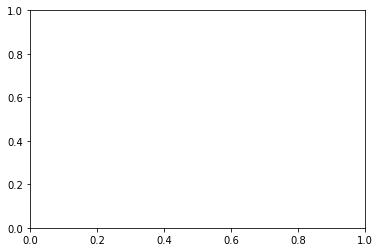

In [112]:
plt.hist2d(range(number_generations+1),model.groups[2].list_of_rank_quality_corrlations,bins=50)
plt.ylim([-1,1])

plt.show()

(-1.0, 1.0)

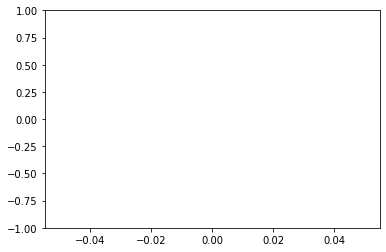

In [113]:
plt.figure()
plt.plot(model.groups[0].list_of_rank_quality_corrlations,'bo')
plt.ylim([-1,1])

(0.0, 1.0)

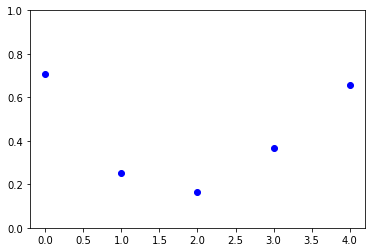

In [114]:
plt.figure()
plt.plot([m.id for m in model.groups[0].males], [m.quality for m in model.groups[0].males],'bo')
plt.ylim([0,1])

In [115]:
np.corrcoef([m.id for m in model.groups[0].males],
            [m.quality for m in model.groups[0].males])[1, 0]

0.006523623764044953

In [ ]:
model.conception_probability_list = [
    .05784435, .16082819, .19820558, .25408223, .24362408, .10373275
]

In [ ]:
g_ = group(0)

In [ ]:
g_.go_one_day()
g_.go_one_day()

ID, Today_Conc_Prob, Tot_Conc_Prob_f = [], [], []
Rank, Quality, Tot_Conc_Prob_m = [], [], []

for f in g_.females_cycling + g_.females_finished_cycling + g_.females_not_yet_cycling:
    ID.append(int(f.id))
    Today_Conc_Prob.append(f.conception_probability)
    Tot_Conc_Prob_f.append(round(sum(g_.mating_matrix[f.id]), 2))

for m in g_.males:
    Rank.append(int(m.id))
    Quality.append(m.quality)
    Tot_Conc_Prob_m.append(round(sum(g_.mating_matrix.T[m.id]), 2))

df_f = pd.DataFrame({
    'ID': ID,
    'Today_Conc_Prob': Today_Conc_Prob,
    'Tot_Conc_Prob': Tot_Conc_Prob_f
}).sort_values(by=['ID']).set_index(['ID', 'Today_Conc_Prob', 'Tot_Conc_Prob'])

df_m = pd.DataFrame({
    'Rank': Rank,
    'Quality': Quality,
    'Tot_Conc_Prob': Tot_Conc_Prob_m
}).set_index(['Rank', 'Quality', 'Tot_Conc_Prob'])

display(df_f, df_m)

In [ ]:
g_.go_one_day()
[f.days_until_cycling for f in g_.females_not_yet_cycling]

In [ ]:
g_.go_one_day()
[f.days_until_conception for f in g_.females_cycling]

In [ ]:
[f.conception_probability for f in g_.females_cycling]

In [ ]:
g_.mating_matrix

In [ ]:
[f.id for f in g_.females_cycling],[m.id for m in g_.males]

In [ ]:
g_.determine_next_gen_parents()
g_.parents

In [129]:
a = np.array([1,2])
b = a
b = np.append(b,3)
a

array([1, 2])